In [130]:
import string
import numpy as np
import csv
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


characters = sorted(set(string.ascii_letters.lower()))

dict_char = dict(zip(characters, range(len(characters))))
counts = np.zeros(len(characters), dtype='uint64')

line_count = 0
y = " "

filename = 'googlebooks-eng-all-1gram-20090715-1.csv'

with open(filename, 'r') as mycsv:
    reader = csv.reader(mycsv)
    for line in reader:
        lines = y.join(line)
        fields = lines.lower().strip().split()
        line_count += 1
        if line_count % 100000 == 0:
            print(filename, line_count)
            break
        count = int(fields[2])
        word = fields[0]
            
        if "_" in word:
            continue

            letters = [char for char in word if char in characters]

            if len(letters) != len(word):
                continue

    for letter in letters:
        if letter not in dict_char:
            continue

        counts[dict_char[letter]] += count

total = np.sum(counts)
list_char = list(dict_char.items())
list_char.sort(key=lambda x: x[1])

for key, value in enumerate(list_char):
    print(value[0], counts[key]/total)

googlebooks-eng-all-1gram-20090715-1.csv 100000
a 0.14285714285714285
b 0.0
c 0.0
d 0.0
e 0.0
f 0.0
g 0.14285714285714285
h 0.0
i 0.14285714285714285
j 0.0
k 0.0
l 0.14285714285714285
m 0.0
n 0.14285714285714285
o 0.0
p 0.0
q 0.0
r 0.0
s 0.14285714285714285
t 0.0
u 0.0
v 0.0
w 0.0
x 0.0
y 0.14285714285714285
z 0.0


# Visualization
we'll start by making a snap visualization of the probability distributions for each language. The first step is to load up the language character frequency from the file.

Text(0, 0.5, 'P(letter)')

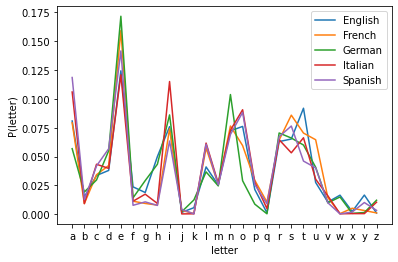

In [129]:
P_letter_lang = pd.read_csv('table_data.txt', sep=' ', header=0, index_col = 0)

plt.plot(range(26), np.array(P_letter_lang["eng"]), '-')
plt.plot(range(26), np.array(P_letter_lang["fre"]), '-')
plt.plot(range(26), np.array(P_letter_lang["ger"]), '-')
plt.plot(range(26), np.array(P_letter_lang["ita"]), '-')
plt.plot(range(26), np.array(P_letter_lang["spa"]), '-')
plt.xticks(list(range(26)), P_letter_lang.index)
plt.legend(["English", "French", "German", "Italian", "Spanish"])
plt.xlabel("letter")
plt.ylabel("P(letter)")

# The detector
Based on this table of data it is extremely simple to build a naive bayes classifier. To do so we have to calculate the correct set of log likelihoods so we can use them later on.

In [124]:
def process_data(P_letter_lang):
    langs = list(P_letter_lang.columns)

    P_letter = P_letter_lang.mean(axis=1)
    P_letter /= P_letter.sum()
    P = P_letter.to_numpy()
    
    P_lang_letter = np.array(P_letter_lang)/(P_letter_lang.shape[1]*P.T[:,None])

    L_lang_letter = np.log(P_lang_letter.T)

    return langs, P_letter, L_lang_letter

In [125]:
langs, P_letter, L_lang_letter = process_data(P_letter_lang)

In [126]:
def detect_lang(langs, P_letter, L_lang_letter, text):
    counts = np.zeros(26, dtype='int')
    pos = dict(zip(P_letter.index, range(26)))

    text_counts =  Counter(text).items()

    for letter, count in text_counts:
        if letter in pos:
            counts[pos[letter]] += count

    L_text = np.dot(L_lang_letter, counts)
    index = np.argmax(L_text)
    lang_text = langs[index]
    prob = np.exp(L_text[index])/np.sum(np.exp(L_text))*100

    return lang_text, prob, L_text

# Test the detector

With a few past headlines from Google news.

In [128]:
texts = {}
texts["eng"] = "Covid-19: Cutting self-isolation to five days would be helpful, Nadhim Zahawi says".lower()
texts["ita"] = "Covid oggi Italia, 155.659 contagi e 157 morti: bollettino 9 gennaio".lower()
texts["fre"] = "Vigilance crues : risque d'inondation dans l'Aude et les Pyrénées-Orientales jusqu'à lundi".lower()
texts["spa"] = "Estados Unidos amenaza con una “respuesta militar masiva” a Corea del Norte".lower()
texts["ger"] = "Scholz droht Impfpflicht-Debakel: Kommt die Italien-Regelung?".lower()

for lang in texts:
    text = texts[lang]
    lang_text, prob, L_text = detect_lang(langs, P_letter, L_lang_letter, text)
    print(lang, lang_text, prob, text)

eng eng 99.9747655346553 covid-19: cutting self-isolation to five days would be helpful, nadhim zahawi says
ita ita 99.50580760283559 covid oggi italia, 155.659 contagi e 157 morti: bollettino 9 gennaio
fre fre 83.58643456668015 vigilance crues : risque d'inondation dans l'aude et les pyrénées-orientales jusqu'à lundi
spa spa 58.428648006919225 estados unidos amenaza con una “respuesta militar masiva” a corea del norte
ger ger 67.65370087324848 scholz droht impfpflicht-debakel: kommt die italien-regelung?


Our language detector is working pretty good.